### Particelle operai a fare la spola

Durante una normale giornata di lavoro in cantiere, gli operai devono portare tutti i pezzi dell'impalcatura dal camion al punto in cui costruire l'impalcatura. per fare ciò usano una catena umana. Alcuni operai scaricano dal camion, uno si occupa di mettere in ordine i materiali e gli altri si dispongono sulla strada dal camion al punto di raccolta. Ogni operaio trasportatore prende un pezzo dell'impalcatura dall'operaio precedente e lo porta per un pezzo di strada fino a raggiungere l'operaio sucessivo. Qui passa il pezzo e torna indietro fino a raggiungere l'operaio precedente e prendere un altro pezzo.

Si vuole adesso modellizzare il comportamento degli operai per vedere se questi movimenti raggiungono uno stato stabile di movimeto di ogni operaio.

Per prima cosa possiamo modellizzare il singolo operaio come un entità o particella e lo spazio in cui queste si muovono come un segmento.

In un primo momento si assume che ogni particella si muova a velocità costante, ma differente per le varie particelle, a prescindere se porti o meno il materiale con sè. assumiamo anche istantaneo l'atto di prendere l'oggetto. Quindi semplicemente si considerano particelle che impattano fra di loro e con i limiti dello spazio. Ad ogni impatto la particella torna indietro con velocità uguale e contraria a prima.

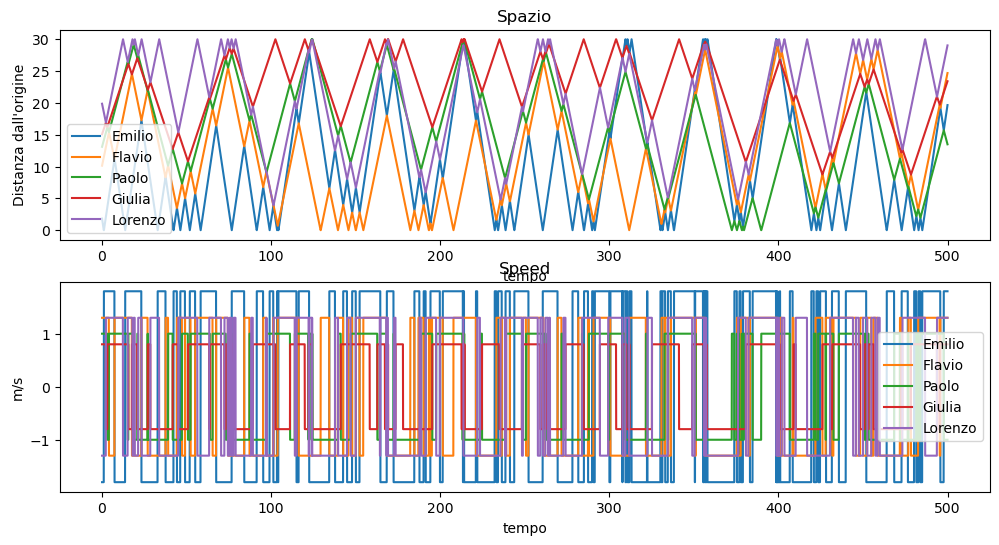

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

def standard_particell_move(time, position, velocity, segment_of_time):
    next_pos = position + velocity*segment_of_time
    return next_pos, velocity

def particel_handler (time: float, particells: list[dict], delta: float, move_func=standard_particell_move):
    # Input validation
    number_of_particells = len(particells)
    if delta <= 0 or number_of_particells <= 0:
        raise ValueError("segment_lenght, delta, and number_of_particells must be positive values.")
    
    # Update positions
    for one_part in particells:
        prec_pos = one_part['position']
        prec_speed = one_part['speed']
        post_pos, prec_speed = move_func(time, prec_pos, prec_speed, delta)
        one_part['position'] = post_pos
        one_part['speed'] = prec_speed
    
    # Collisions for cuples of particells
    first_partcel = particells[0]
    for i in range(1, len(particells)):
        second_partcel = particells[i]
        if second_partcel['position'] - first_partcel['position'] < 0 and first_partcel['speed']*second_partcel['speed'] <= 0:
            first_partcel['speed'] = -first_partcel['speed']
            second_partcel['speed'] = -second_partcel['speed']
            if first_partcel['name'] == 'LeftWall':
                avg_pos = 0
            elif second_partcel['name'] == 'RightWall':
                avg_pos = second_partcel['position']
            else:
                avg_pos = (first_partcel['position'] + second_partcel['position']) / 2
            first_partcel['position'] = avg_pos
            second_partcel['position'] = avg_pos
        if second_partcel['position'] - first_partcel['position'] < 0 and first_partcel['speed']*second_partcel['speed'] > 0:
            # se si muovono nella stessa direzione scambia le posizioni
            particells[i], particells[i-1] = particells[i-1], particells[i]
        if first_partcel['position'] < 0:
            raise IndexError(f'{first_partcel['name']} Run out of limit')
        first_partcel = second_partcel
    return particells

def personal_solve_ivp(times, particell, delta, particells_movement, move_func=standard_particell_move ):
    for time in times:
        particell = particel_handler(time, particell, delta, move_func)
        for part in particell[1:-1]:
            name = part['name']
            particells_movement[name]["positions"].append(part['position'])
            particells_movement[name]["speeds"].append(part['speed'])
    return particells_movement

def particell_plotter(particells_movement, times):
# Extract solutions
    t = times
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    for name, movement in particells_movement.items():
        singular_positions = movement["positions"][1:]
        plt.plot(t, singular_positions, label=name )
    plt.xlabel('tempo')
    plt.ylabel("Distanza dall'origine")
    plt.title('Spazio')
    plt.legend()

    plt.subplot(2, 1, 2)
    for name, movement in particells_movement.items():
        singular_speeds = movement["speeds"][1:]
        plt.plot(t, singular_speeds, label=name )
    plt.xlabel('tempo')
    plt.ylabel('m/s')
    plt.title('Speed')
    plt.legend()

# Intervallo di integrazione
delta = 0.1
max_time = 500
worker = [{'name': 'LeftWall', 'position': 0, 'speed': 0},
          {'name': 'Emilio', 'position': 2, 'speed': -1.8},
          {'name': 'Flavio', 'position': 10, 'speed': 1.3},
          {'name': 'Paolo', 'position': 13, 'speed': 1},
          {'name': 'Giulia', 'position': 15, 'speed': 0.8},
          {'name': 'Lorenzo', 'position': 20, 'speed': -1.3},
          {'name': 'RightWall', 'position': 30, 'speed': 0},
    ]
worker_movement = dict()
for part in worker[1:-1]: # initialization
    worker_movement[part['name']] = { "positions" : [part['position']], "speeds" : [part['speed']]}
times = np.arange(delta, max_time + delta, delta)

# generiamo le varie soluzioni del sistema

worker_movement = personal_solve_ivp(times, worker, delta, worker_movement )

particell_plotter(worker_movement, times)

Vediamo come ci sia una ciclicità nei movimenti delle particelle, ma non sia particolarmente interessante. Molto probabilmente è dovuta ai numeri scelti che hanno delle proporzioni particolari.

Proviamo allora ad aggiungere un po' di variazione nela velocità delle varie particelle

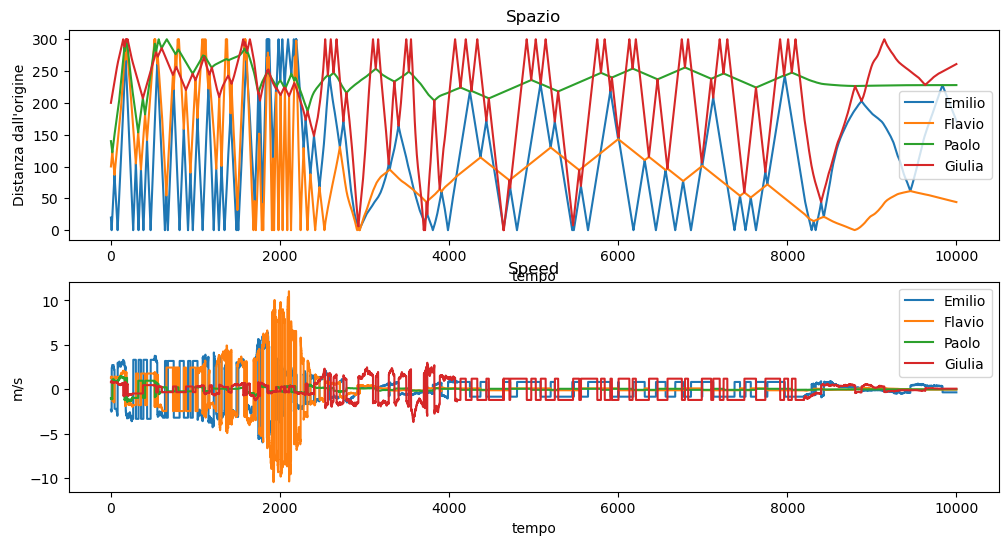

In [7]:
def logaritmicParticellMove(time, position, velocity, segment_of_time):
    next_pos = (position +
                np.sign(velocity) 
                * np.emath.logn(abs(velocity*segment_of_time), 1.2)
                * np.emath.logn(time+1, 20))
    return next_pos, velocity

def GaussianParticellMove(time, position, velocity, segment_of_time):
    if time%2 == 0:
        velocity += (np.random.random()-0.5)*(velocity)*0.2
    next_pos = (position + velocity*segment_of_time)
    return next_pos, velocity

delta = 0.1
max_time = 10000
particell = [{'name': 'LeftWall', 'position': 0, 'speed': 0},
          {'name': 'Emilio', 'position': 20, 'speed': -2.3},
          {'name': 'Flavio', 'position': 100, 'speed': 1.3},
          {'name': 'Paolo', 'position': 140, 'speed': -1},
          {'name': 'Giulia', 'position': 200, 'speed': 0.8},
          {'name': 'RightWall', 'position': 300, 'speed': 0},
    ]
particells_movement = dict()
for part in particell[1:-1]: # initialization
    particells_movement[part['name']] = { "positions" : [part['position']], "speeds" : [part['speed']]}
times = np.arange(delta, max_time + delta, delta)

# generiamo le varie soluzioni del sistema

particells_movement = personal_solve_ivp(times, particell, delta, particells_movement, GaussianParticellMove )

particell_plotter(particells_movement, times)    